In [40]:
from google.colab import drive
drive.mount('/content/drive')
import warnings

# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
%reload_ext autoreload
%autoreload 2

import gc
import random

# numpy et pandas pour la manipulation du data
import numpy as np
import pandas as pd

# sklearn
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing, model_selection, linear_model, metrics, impute, ensemble
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials, space_eval

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour tracer les graphes
import matplotlib.pyplot as plt

#autres librairies
import missingno as msno

In [42]:
# Specify the correct path to your CSV file in Google Drive
csv_path = '/content/drive/MyDrive/openclass/df.csv'
# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,description_tokens,clean_description_tokens,lemmatized_description_tokens,cluster_labels
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","['Key', 'Features', 'of', 'Elegance', 'Polyest...","['Key', 'Features', 'Elegance', 'Polyester', '...","['Key', 'Features', 'Elegance', 'Polyester', '...",5
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","['Specifications', 'of', 'Sathiyas', 'Cotton',...","['Specifications', 'Sathiyas', 'Cotton', 'Bath...","['Specifications', 'Sathiyas', 'Cotton', 'Bath...",6
2,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...","['Key', 'Features', 'of', 'SANTOSH', 'ROYAL', ...","['Key', 'Features', 'SANTOSH', 'ROYAL', 'FASHI...","['Key', 'Features', 'SANTOSH', 'ROYAL', 'FASHI...",4
3,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...","['Key', 'Features', 'of', 'Jaipur', 'Print', '...","['Key', 'Features', 'Jaipur', 'Print', 'Cotton...","['Key', 'Features', 'Jaipur', 'Print', 'Cotton...",4
4,b85f8843bb1c297dd5712f0bd287006d,2016-06-12 08:33:38 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Embroidered Diwan...,"[""Home Furnishing >> Living Room Furnishing >>...",DSTEJJEXFWXKBDYM,2199.0,979.0,b85f8843bb1c297dd5712f0bd287006d.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton E...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...","['Key', 'Features', 'of', 'SANTOSH', 'ROYAL', ...","['Key', 'Features', 'SANTOSH', 'ROYAL', 'FASHI...","['Key', 'Features', 'SANTOSH', 'ROYAL', 'FASHI...",4


In [43]:
#Création des labels des images
#Création d'un DataFrame avec :
#nom du fichier image (image)
#nom de la catégorie (label_name)
#numéro de la catégorie (label)
# Récupération des noms de catégories principales
from sklearn.preprocessing import LabelEncoder
df['label_name'] = df['product_category_tree'].apply(lambda x: x.split('["')[1].split(' >>')[0])

# Encodage des labels
category_label_encoder = LabelEncoder()
df['label'] = category_label_encoder.fit_transform(df['label_name'])

display(df)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,product_rating,overall_rating,brand,product_specifications,description_tokens,clean_description_tokens,lemmatized_description_tokens,cluster_labels,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","['Key', 'Features', 'of', 'Elegance', 'Polyest...","['Key', 'Features', 'Elegance', 'Polyester', '...","['Key', 'Features', 'Elegance', 'Polyester', '...",5,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","['Specifications', 'of', 'Sathiyas', 'Cotton',...","['Specifications', 'Sathiyas', 'Cotton', 'Bath...","['Specifications', 'Sathiyas', 'Cotton', 'Bath...",6,Baby Care,0
2,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...","['Key', 'Features', 'of', 'SANTOSH', 'ROYAL', ...","['Key', 'Features', 'SANTOSH', 'ROYAL', 'FASHI...","['Key', 'Features', 'SANTOSH', 'ROYAL', 'FASHI...",4,Home Furnishing,4
3,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...","['Key', 'Features', 'of', 'Jaipur', 'Print', '...","['Key', 'Features', 'Jaipur', 'Print', 'Cotton...","['Key', 'Features', 'Jaipur', 'Print', 'Cotton...",4,Home Furnishing,4
4,b85f8843bb1c297dd5712f0bd287006d,2016-06-12 08:33:38 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Embroidered Diwan...,"[""Home Furnishing >> Living Room Furnishing >>...",DSTEJJEXFWXKBDYM,2199.0,979.0,b85f8843bb1c297dd5712f0bd287006d.jpg,False,...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...","['Key', 'Features', 'of', 'SANTOSH', 'ROYAL', ...","['Key', 'Features', 'SANTOSH', 'ROYAL', 'FASHI...","['Key', 'Features', 'SANTOSH', 'ROYAL', 'FASHI...",4,Home Furnishing,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...","['Oren', 'Empower', 'Extra', 'Large', 'Self', ...","['Oren', 'Empower', 'Extra', 'Large', 'Self', ...","['Oren', 'Empower', 'Extra', 'Large', 'Self', ...",1,Baby Care,0
706,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care

# Word2vec

In [46]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Prétraitement des données
# Vous pouvez définir ici vos propres fonctions de prétraitement des descriptions de produits

# Entraînement du modèle Word2Vec
sentences = df['lemmatized_description_tokens'].apply(eval).tolist()
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)

# Création des embeddings pour chaque description de produit
def get_embeddings(tokens):
    embeddings = []
    for token in tokens:
        if token in model.wv:
            embeddings.append(model.wv[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

df['word2vec_embeddings'] = df['lemmatized_description_tokens'].apply(lambda x: get_embeddings(x))

In [47]:
# Convertir les embeddings Word2Vec en un tableau NumPy
word2vec_embeddings_array = np.array(df['word2vec_embeddings'].tolist())

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
word2vec_tsne_embeddings = tsne.fit_transform(word2vec_embeddings_array)


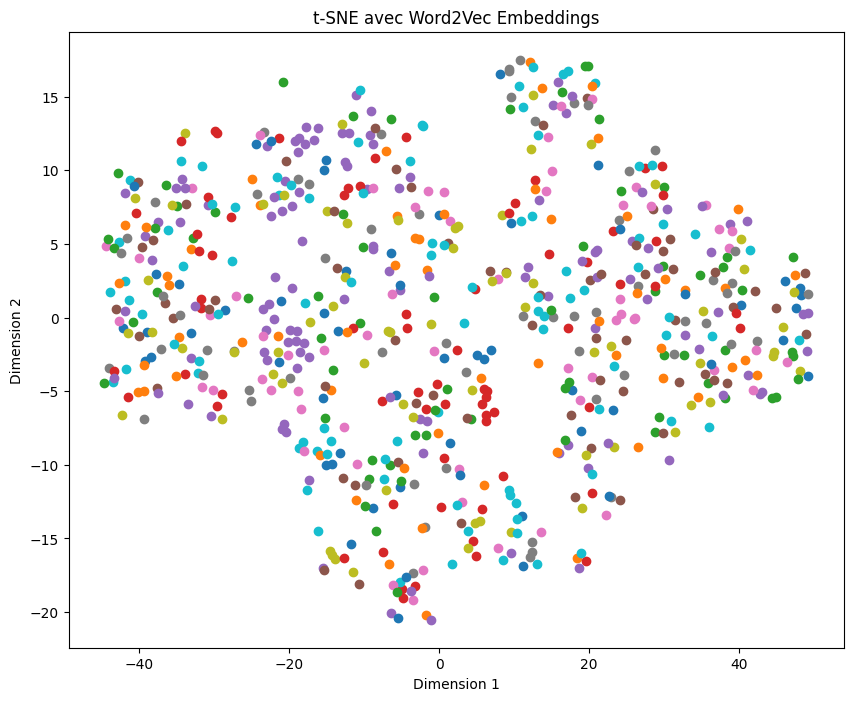

In [48]:
# Coloration des points par catégories réelles
plt.figure(figsize=(10, 8))
for category in df['product_category_tree'].unique():
    plt.scatter(word2vec_tsne_embeddings[df['product_category_tree'] == category][:, 0],
                word2vec_tsne_embeddings[df['product_category_tree'] == category][:, 1],
                label=category)
plt.title('t-SNE avec Word2Vec Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Comparaison de l'ARI avec TF-IDF (à faire)
# Vous devrez comparer l'ARI obtenu avec Word2Vec avec celui obtenu précédemment avec TF-IDF


ARI avec Word2Vec: 0.2390172759426602
ARI avec TF-IDF: 0.028060752988776774


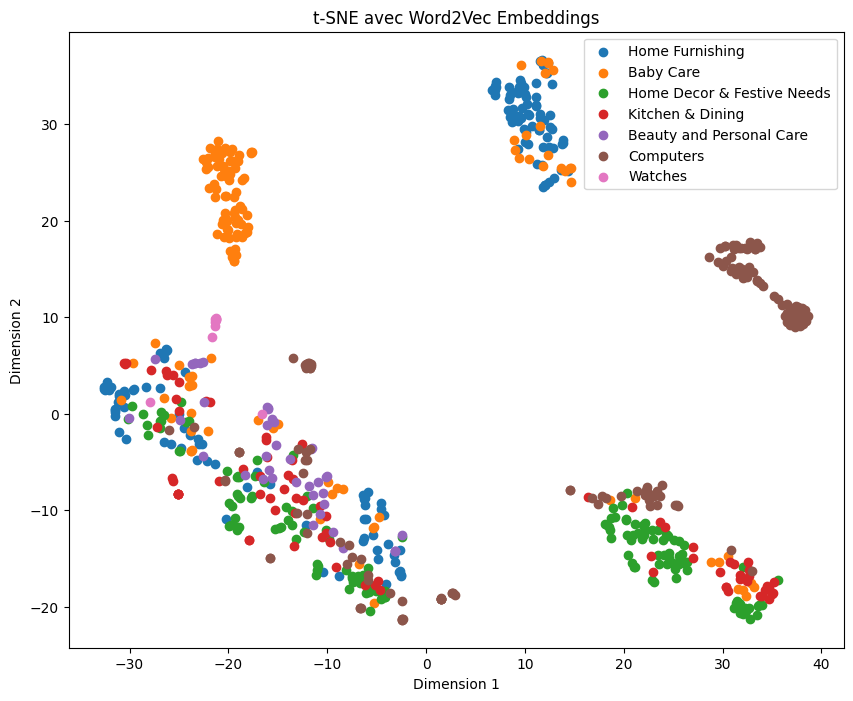

In [49]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

# Prétraitement des données
# Vous pouvez définir ici vos propres fonctions de prétraitement des descriptions de produits

# Entraînement du modèle Word2Vec
sentences = df['lemmatized_description_tokens'].apply(eval).tolist()
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)

# Création des embeddings pour chaque description de produit
def get_embeddings(tokens):
    embeddings = []
    for token in tokens:
        if token in model.wv:
            embeddings.append(model.wv[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

df['word2vec_embeddings'] = df['lemmatized_description_tokens'].apply(lambda x: get_embeddings(eval(x)))

# Convertir les embeddings Word2Vec en un tableau NumPy
word2vec_embeddings_array = np.array(df['word2vec_embeddings'].tolist())

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
word2vec_tsne_embeddings = tsne.fit_transform(word2vec_embeddings_array)

# Clustering KMeans sur les embeddings Word2Vec réduits par t-SNE
kmeans = KMeans(n_clusters=7, random_state=42)
predicted_word2vec_clusters = kmeans.fit_predict(word2vec_tsne_embeddings)

# Utilisation de la colonne 'product_category_tree' comme les catégories réelles
# Assurez-vous que cette colonne contient les catégories formatées de manière appropriée
# Ici, nous extrayons les catégories principales de 'product_category_tree'
df['main_category'] = df['product_category_tree'].apply(lambda x: eval(x)[0].split(" >> ")[0])

# Calcul du score ARI
ari_word2vec = adjusted_rand_score(df['main_category'], predicted_word2vec_clusters)

# Affichage du score ARI
print("ARI avec Word2Vec:", ari_word2vec)

# Comparaison avec l'ancien score ARI avec TF-IDF
ari_tfidf = 0.028060752988776774  # Score ARI TF-IDF précédemment calculé
print("ARI avec TF-IDF:", ari_tfidf)

# Visualisation des points t-SNE colorés par catégories réelles
plt.figure(figsize=(10, 8))
for category in df['main_category'].unique():
    plt.scatter(word2vec_tsne_embeddings[df['main_category'] == category][:, 0],
                word2vec_tsne_embeddings[df['main_category'] == category][:, 1],
                label=category)
plt.title('t-SNE avec Word2Vec Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


# Bert

In [50]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch

# Charger le modèle BERT et le tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Fonction pour obtenir les embeddings BERT pour une description de produit
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


In [51]:
# Appliquer la fonction sur les descriptions des produits
df['bert_embeddings'] = df['lemmatized_description_tokens'].apply(lambda x: get_bert_embeddings(" ".join(eval(x))))

# Convertir les embeddings BERT en un tableau NumPy
bert_embeddings_array = np.array(df['bert_embeddings'].tolist())

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
bert_tsne_embeddings = tsne.fit_transform(bert_embeddings_array)

# Clustering KMeans sur les embeddings BERT réduits par t-SNE
kmeans = KMeans(n_clusters=7, random_state=42)
predicted_bert_clusters = kmeans.fit_predict(bert_tsne_embeddings)

# Calcul du score ARI
df['main_category'] = df['product_category_tree'].apply(lambda x: eval(x)[0].split(" >> ")[0])
ari_bert = adjusted_rand_score(df['main_category'], predicted_bert_clusters)

# Affichage du score ARI
print("ARI avec BERT:", ari_bert)

ARI avec BERT: 0.3160916833723786


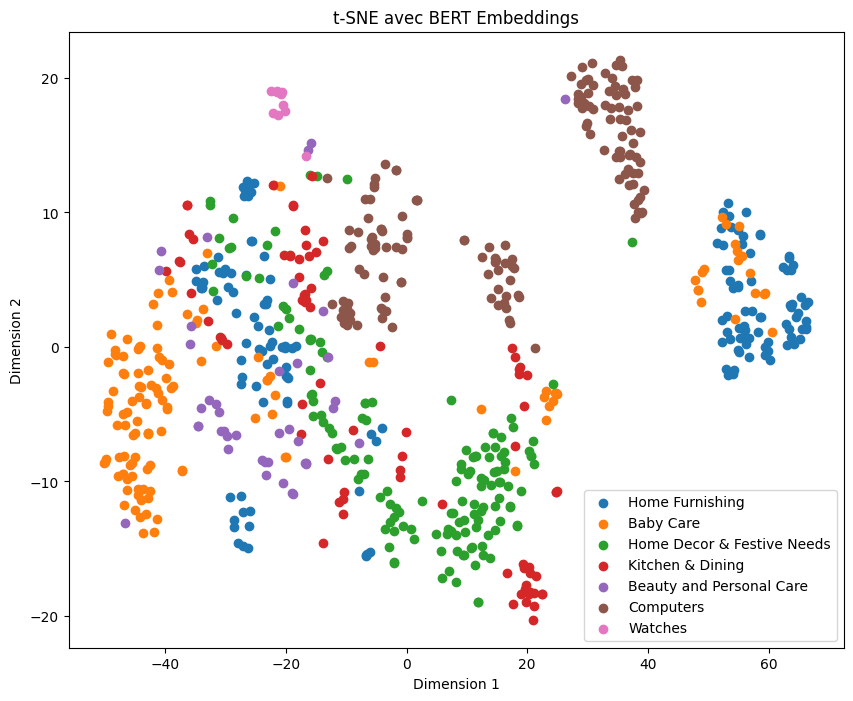

In [52]:
# Visualisation des points t-SNE colorés par catégories réelles
plt.figure(figsize=(10, 8))
for category in df['main_category'].unique():
    plt.scatter(bert_tsne_embeddings[df['main_category'] == category][:, 0],
                bert_tsne_embeddings[df['main_category'] == category][:, 1],
                label=category)
plt.title('t-SNE avec BERT Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


# USE

ARI avec USE: 0.34010444964501146


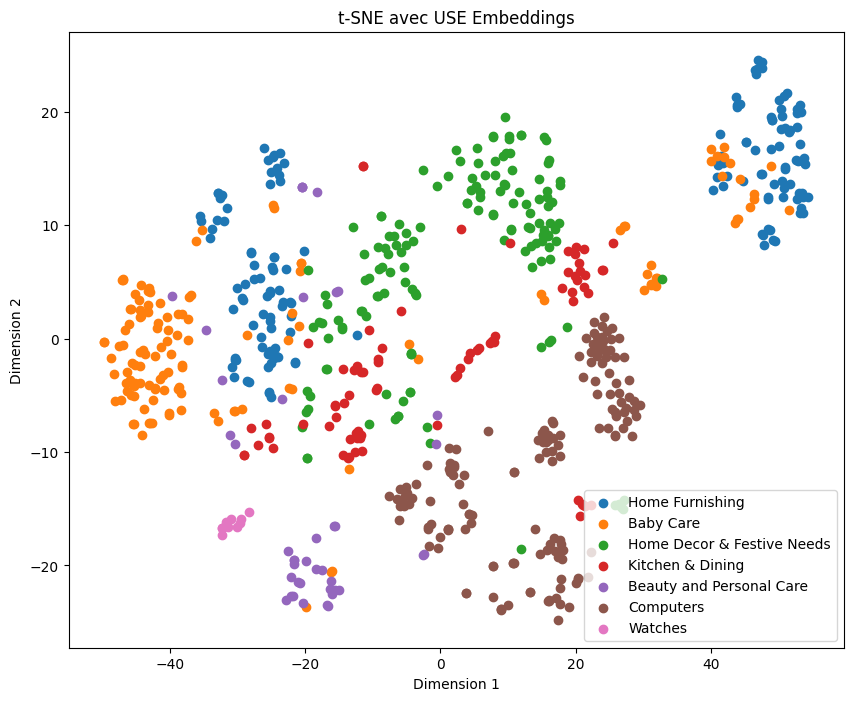

In [53]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import tensorflow_hub as hub

# Charger le modèle USE
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Fonction pour obtenir les embeddings USE pour une description de produit
def get_use_embeddings(text):
    return use_model([text]).numpy().squeeze()

# Appliquer la fonction sur les descriptions des produits
df['use_embeddings'] = df['clean_description_tokens'].apply(lambda x: get_use_embeddings(" ".join(eval(x))))

# Convertir les embeddings USE en un tableau NumPy
use_embeddings_array = np.array(df['use_embeddings'].tolist())

# Réduction de dimensionnalité avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
use_tsne_embeddings = tsne.fit_transform(use_embeddings_array)

# Clustering KMeans sur les embeddings USE réduits par t-SNE
kmeans = KMeans(n_clusters=7, random_state=42)
predicted_use_clusters = kmeans.fit_predict(use_tsne_embeddings)

# Calcul du score ARI
df['main_category'] = df['product_category_tree'].apply(lambda x: eval(x)[0].split(" >> ")[0])
ari_use = adjusted_rand_score(df['main_category'], predicted_use_clusters)

# Affichage du score ARI
print("ARI avec USE:", ari_use)

# Visualisation des points t-SNE colorés par catégories réelles
plt.figure(figsize=(10, 8))
for category in df['main_category'].unique():
    plt.scatter(use_tsne_embeddings[df['main_category'] == category][:, 0],
                use_tsne_embeddings[df['main_category'] == category][:, 1],
                label=category)
plt.title('t-SNE avec USE Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


In [54]:
# Affichage des scores ARI
print("ARI avec TF-IDF:", ari_tfidf)  # Supposons que ce score ait été calculé précédemment
print("ARI avec Word2Vec:", ari_word2vec)  # Supposons que ce score ait été calculé précédemment
print("ARI avec BERT:", ari_bert)
print("ARI avec USE:", ari_use)


ARI avec TF-IDF: 0.028060752988776774
ARI avec Word2Vec: 0.2390172759426602
ARI avec BERT: 0.3160916833723786
ARI avec USE: 0.34010444964501146


ARI avec TF-IDF: 0.028060752988776774

Le score ARI très faible pour TF-IDF indique que cette méthode de vectorisation ne capture pas efficacement la structure des catégories de produits dans les données. TF-IDF fonctionne bien pour des tâches comme la récupération d'information et la recherche, mais peut ne pas capturer suffisamment bien le contexte pour le clustering.

ARI avec Word2Vec: 0.2390172759426602

Le score ARI avec Word2Vec est nettement supérieur à celui de TF-IDF. Word2Vec est capable de capturer des relations contextuelles entre les mots, ce qui permet une meilleure représentation des descriptions de produits et améliore le clustering.

ARI avec BERT: 0.3160916833723786

Le score ARI avec BERT est encore meilleur que celui de Word2Vec. BERT, étant un modèle de langage pré-entraîné bidirectionnel, capture des relations contextuelles plus complexes et de manière plus fine, ce qui se traduit par une meilleure performance dans la tâche de clustering.

ARI avec Universal Sentence Encoder (USE): 0.34010444964501146

Le score ARI le plus élevé est obtenu avec USE. USE est conçu spécifiquement pour encoder des phrases ou des textes courts en vecteurs, capturant à la fois les informations contextuelles et syntaxiques. Cela le rend particulièrement adapté pour les tâches de clustering de textes.
